In [ ]:
# !pip install timm
import timm 
timm.list_models(pretrained=True)

In [82]:

import torch

device = 'cuda:1'
model_name = ['efficientnet_b0', 'xception']
model = timm.create_model(model_name[1],num_classes=2, pretrained=True).to(device)

/home/tako/anaconda3/envs/ilwoong/lib/python3.9/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [84]:
import pandas as pd
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import os
import cv2

class CustomDataset(Dataset):
    def __init__(self,  img_dir, files,transform=None):
        self.img_labels = files
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        image = cv2.imread(img_path)
        if 'fake' in img_path:
            label=torch.LongTensor([0])
        else:
            label=torch.LongTensor([1])
        if self.transform:
            image = self.transform(image)
        return image.to(device), label.to(device)


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])
hqf2f = 'High Quality/f2f_data'
hqnt = 'High Quality/nt_data'
lqf2f = 'Low Quality/f2f_data'
lqnt = 'Low Quality/nt_data'

file_dir = hqnt # Have to change dataset path if you want

test_dir = file_dir+'/test'
train_dir = file_dir+'/train'
valid_dir = file_dir +'/val'
testimages = os.listdir(test_dir)
trainimages = os.listdir(train_dir)
validimages = os.listdir(valid_dir)

test_dataset = CustomDataset(test_dir, testimages, transform)
train_dataset = CustomDataset(train_dir, trainimages, transform)
valid_dataset = CustomDataset(valid_dir, validimages, transform)
batchsize = 32
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=True)



In [85]:
from torch.nn import CrossEntropyLoss
from torch import optim
loss_func = CrossEntropyLoss()
epoch = 100
optimizer = optim.AdamW(model.parameters())
train_losses =[]
train_accuracy =[]
valid_losses =[]
valid_accuracy =[]
for i in range(epoch):
    total = 0
    train_correct = 0
    epoch_loss =0
    model.train()
    for batch, (image ,label) in enumerate(train_dataloader):
        prediction = model(image)
        label = label.squeeze(dim=1)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(prediction, 1)
        total += label.size(0)
        train_correct += (predicted.cpu() == label.cpu()).sum().item()
        epoch_loss += loss  
    
    epoch_loss /= len(train_dataloader)
    train_losses.append(epoch_loss.item())
    train_accuracy.append(train_correct / total)

    if i % 2 == 0:
        print(i)
        model.eval()
        with torch.no_grad():
            valid_total =0
            valid_loss =0
            valid_correct = 0
            for batch , (image, label) in enumerate(valid_dataloader):
                prediction = model(image)
                label = label.squeeze(dim=1)
                valid_loss += loss_func(prediction, label)
                valid_total += label.size(0)
                _, predicted = torch.max(prediction,1)
                valid_correct += (predicted.cpu() == label.cpu()).sum().item()

            valid_loss /= len(valid_dataloader)
            valid_losses.append(valid_loss.item()) 
            valid_accuracy.append(valid_correct / valid_total)
    

0
2
4
6
8
10
12
14
16
18
20
22
24


# Accuracy plot

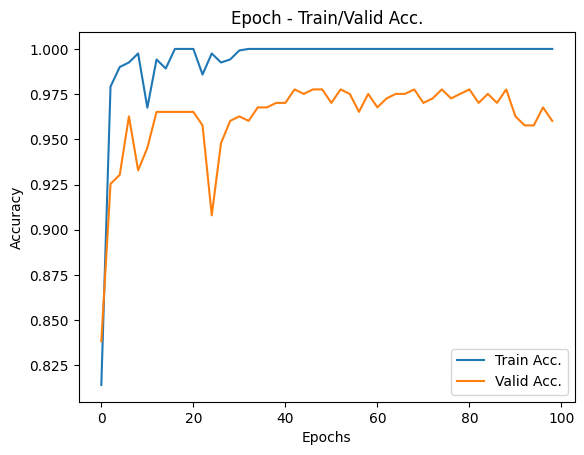

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

modelname = str(model).split('(')[0]
dataname = file_dir.split('/')[0] + '_'+file_dir.split('/')[1]
epochs = list(np.arange(0, 100, 2, dtype=np.int32))
train_accuracy = [train_accuracy[i] for i in epochs]

plt.plot(epochs, train_accuracy, label='Train Acc.')
plt.plot(epochs, valid_accuracy, label='Valid Acc.')

plt.title('Epoch - Train/Valid Acc.')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'{modelname}_{dataname}_accuracy')
plt.show()

# Loss plot

In [ ]:
train_losses = [train_losses[i] for i in epochs]
plt.plot(epochs, train_losses, label='Train Loss.')
plt.plot(epochs, valid_losses, label='Valid Loss.')

plt.title('Epoch - Train/Valid losses.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{modelname}_{dataname}_Loss')
plt.show()

# Accuracy, F1-score, Precision, Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


test_dataloader = DataLoader(test_dataset, batch_size=batchsize)
with torch.no_grad():
    test_total =0
    test_loss =0
    test_correct = 0
    test_predicts =[]
    test_labels=[]
    for batch , (image, label) in enumerate(test_dataloader):
        prediction = model(image)
        label = label.squeeze(dim=1)
        test_loss += loss_func(prediction, label)
        test_total += label.size(0)
        _, predicted = torch.max(prediction,1)
        test_correct += (predicted.cpu() == label.cpu()).sum().item()
        test_predicts.append(predicted)
        test_labels.append(label)

    test_predicts = torch.cat(test_predicts,dim=0).detach().cpu().numpy()
    test_labels = torch.cat(test_labels, dim=0).detach().cpu().numpy()
    precision = precision_score(test_labels, test_predicts)
    recall = recall_score(test_labels, test_predicts)
    f1 = f1_score(test_labels, test_predicts)
    test_loss /= len(test_dataloader)
    test_accuracy=test_correct / test_total

    print('test_accuracy: ' , test_accuracy)
    print('F1-score: ' ,f1)
    print('Precision: ', precision, " Recall: ",recall)

test_accuracy:  0.7035175879396985
F1-score:  0.6927083333333334
Precision:  0.7189189189189189  Recall:  0.6683417085427136


# Save to Json

In [ ]:
import json
result = {'model': modelname,
          'dataset': dataname,
          'Acc' : test_accuracy,
          'F1-score' : f1,
          'Precision' : precision,
          'Recall': recall}
with open(f'result/{modelname}_{dataname}.json', 'x') as f:
    json.dump(result, f, indent=4)